In [ ]:
import os, shutil, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from tensorflow.keras import layers, models


# ------ SETTINGS -------
initial_direction = "Dataset"                   
CLASSES = ["PC", "Laptop", "Smartphone"]     

output_direction = "dataset_split"
TRAIN_RATIO = 0.8
SEED = 42

IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 15

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


## Step 1 — Train/Test Split
We split images into:
- `dataset_split/train/<class>`
- `dataset_split/test/<class>`

This makes it easy to load images with auto labels (folder names become labels).


In [1]:
#------ SPLIT DATASET -------
def reset_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

reset_folder(output_direction)

for cls in CLASSES:
    src = os.path.join(initial_direction, cls)
    if not os.path.exists(src):
        raise FileNotFoundError(f"Folder not found: {src}")
    
    files = [f for f in os.listdir(src)
             if os.path.isfile(os.path.join(src, f)) and f.lower().endswith(".jpg")]

    random.shuffle(files)
    split_idx = int(len(files) * TRAIN_RATIO)
    train_files = files[:split_idx]
    test_files  = files[split_idx:]

    train_datasett = os.path.join(output_direction, "train", cls)
    test_datasett  = os.path.join(output_direction, "test", cls)
    os.makedirs(train_datasett, exist_ok=True)
    os.makedirs(test_datasett, exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(src, f), os.path.join(train_datasett, f))

    for f in test_files:
        shutil.copy(os.path.join(src, f), os.path.join(test_datasett, f))

    print(f"✅ {cls}: Train={len(train_files)} Test={len(test_files)}")

print("\nDone splitting. Output:", output_direction)

NameError: name 'output_direction' is not defined

## Step 2 — Preprocessing (Resize + Normalize)

- **Resize** happens during dataset loading with `image_size=(224,224)`.
- **Normalize** converts pixel values from 0–255 into 0–1 using `x/255.0`.

We display the min/max values to clearly show the effect of normalization.


In [ ]:
# load training dataset
training_dataset = tf.keras.utils.image_dataset_from_directory(
    f"{output_direction}/train",
    image_size=IMG_SIZE, 
    batch_size=BATCH,
    seed=SEED,
    label_mode="int"
)

# load testing dataset
testing_dataset = tf.keras.utils.image_dataset_from_directory(
    f"{output_direction}/test",
    image_size=IMG_SIZE,  
    batch_size=BATCH,
    seed=SEED,
    shuffle=False,
    label_mode="int"
)

class_names = training_dataset.class_names
print("Classes detected:", class_names)

Found 237 files belonging to 3 classes.
Found 61 files belonging to 3 classes.
Classes detected: ['Laptop', 'PC', 'Smartphone']


In [ ]:
# Normalize the pixel values to [0, 1]
AUTOTUNE = tf.data.AUTOTUNE

print("\n=== BEFORE normalization ===")
for x_batch, y_batch in training_dataset.take(1):
    print("dtype:", x_batch.dtype)
    print("min :", tf.reduce_min(x_batch).numpy(), "max:", tf.reduce_max(x_batch).numpy())
    print("shape:", x_batch.shape)

def normalize_01(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_dataset = training_dataset.map(normalize_01).prefetch(AUTOTUNE)
test_dataset  = testing_dataset.map(normalize_01).prefetch(AUTOTUNE)

print("\n=== AFTER normalization (0..1) ===")
for x_batch, y_batch in train_dataset.take(1):
    print("dtype:", x_batch.dtype)
    print("min :", tf.reduce_min(x_batch).numpy(), "max:", tf.reduce_max(x_batch).numpy())


=== BEFORE normalization ===
dtype: <dtype: 'float32'>
min : 0.0 max: 255.0
shape: (32, 224, 224, 3)

=== AFTER normalization (0..1) ===
dtype: <dtype: 'float32'>
min : 0.0 max: 1.0


## Step 3 — Supervised Learning Technique: MobileNetV2 (Transfer Learning)

**Transfer learning**: Use a pretrained model (trained on ImageNet) to extract features.
- `include_top=False`: remove original 1000-class classifier
- `base.trainable=False`: freeze pretrained feature extractor
- Add new classifier head for 3 classes (PC/Laptop/Smartphone)


In [ ]:
#------ BUILD MODEL -------
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print("✅ Model ready")


✅ Model ready


## Step 4 — Train the model
Training updates only the classification head weights (MobileNetV2 base is frozen).

In [ ]:
#------ TRAIN MODEL -------
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - accuracy: 0.7595 - loss: 0.5917 - val_accuracy: 0.9344 - val_loss: 0.1743
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.9662 - loss: 0.0849 - val_accuracy: 0.9508 - val_loss: 0.1027
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.9873 - loss: 0.0440 - val_accuracy: 0.9344 - val_loss: 0.1284
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.9873 - loss: 0.0264 - val_accuracy: 0.9180 - val_loss: 0.1825
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.9344 - val_loss: 0.1529
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.9958 - loss: 0.0102 - val_accuracy: 0.9344 - val_loss: 0.1434
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9344 - val_loss: 0.1410
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9508 - val_loss

<Figure size 600x600 with 0 Axes>

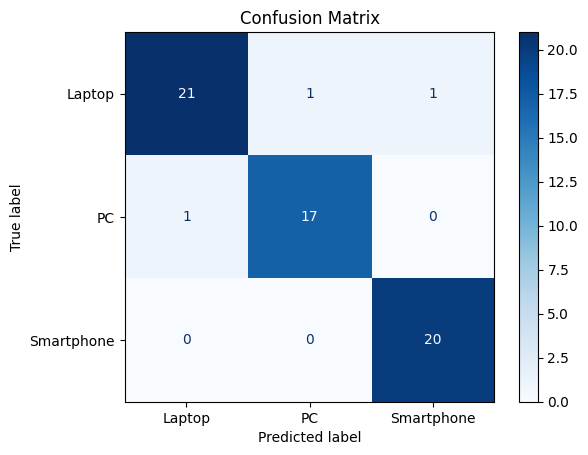

Confusion Matrix:
 [[21  1  1]
 [ 1 17  0]
 [ 0  0 20]]

Classification Report:

              precision    recall  f1-score   support

      Laptop       0.95      0.91      0.93        23
          PC       0.94      0.94      0.94        18
  Smartphone       0.95      1.00      0.98        20

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [ ]:
#------ EVALUATE MODEL -------
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

y_prob = model.predict(test_dataset, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# Display classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))